In [ ]:
!pip install ortools

In [ ]:
import pandas as pd

df = pd.read_excel("tpf-2.xlsx")

In [ ]:
df.head()

,ORDEN DE PRODUCCION,SABOR,FORMATO (CC),UNIDADES
0,OP#0101,CHOCOLATE,200,210000
1,OP#0102,VANILLA,1000,45000
2,OP#0103,NEUTRO,200,175000
3,OP#0104,CHOCOLATE,200,157500
4,OP#0105,CHOCOLATE,200,192500


In [ ]:
reqs = df.groupby(["SABOR", "FORMATO (CC)"]).agg({"UNIDADES": "sum"})
reqs.head()

UNIDADES
SABOR     FORMATO (CC)          
CHOCOLATE 200             927500
          1000             80000
NEUTRO    200             577500
          1000             60000
VANILLA   200             350000

In [ ]:
demanda_df = reqs.reset_index()
demanda_df

,SABOR,FORMATO (CC),UNIDADES
0,CHOCOLATE,200,927500
1,CHOCOLATE,1000,80000
2,NEUTRO,200,577500
3,NEUTRO,1000,60000
4,VANILLA,200,350000
5,VANILLA,1000,80000


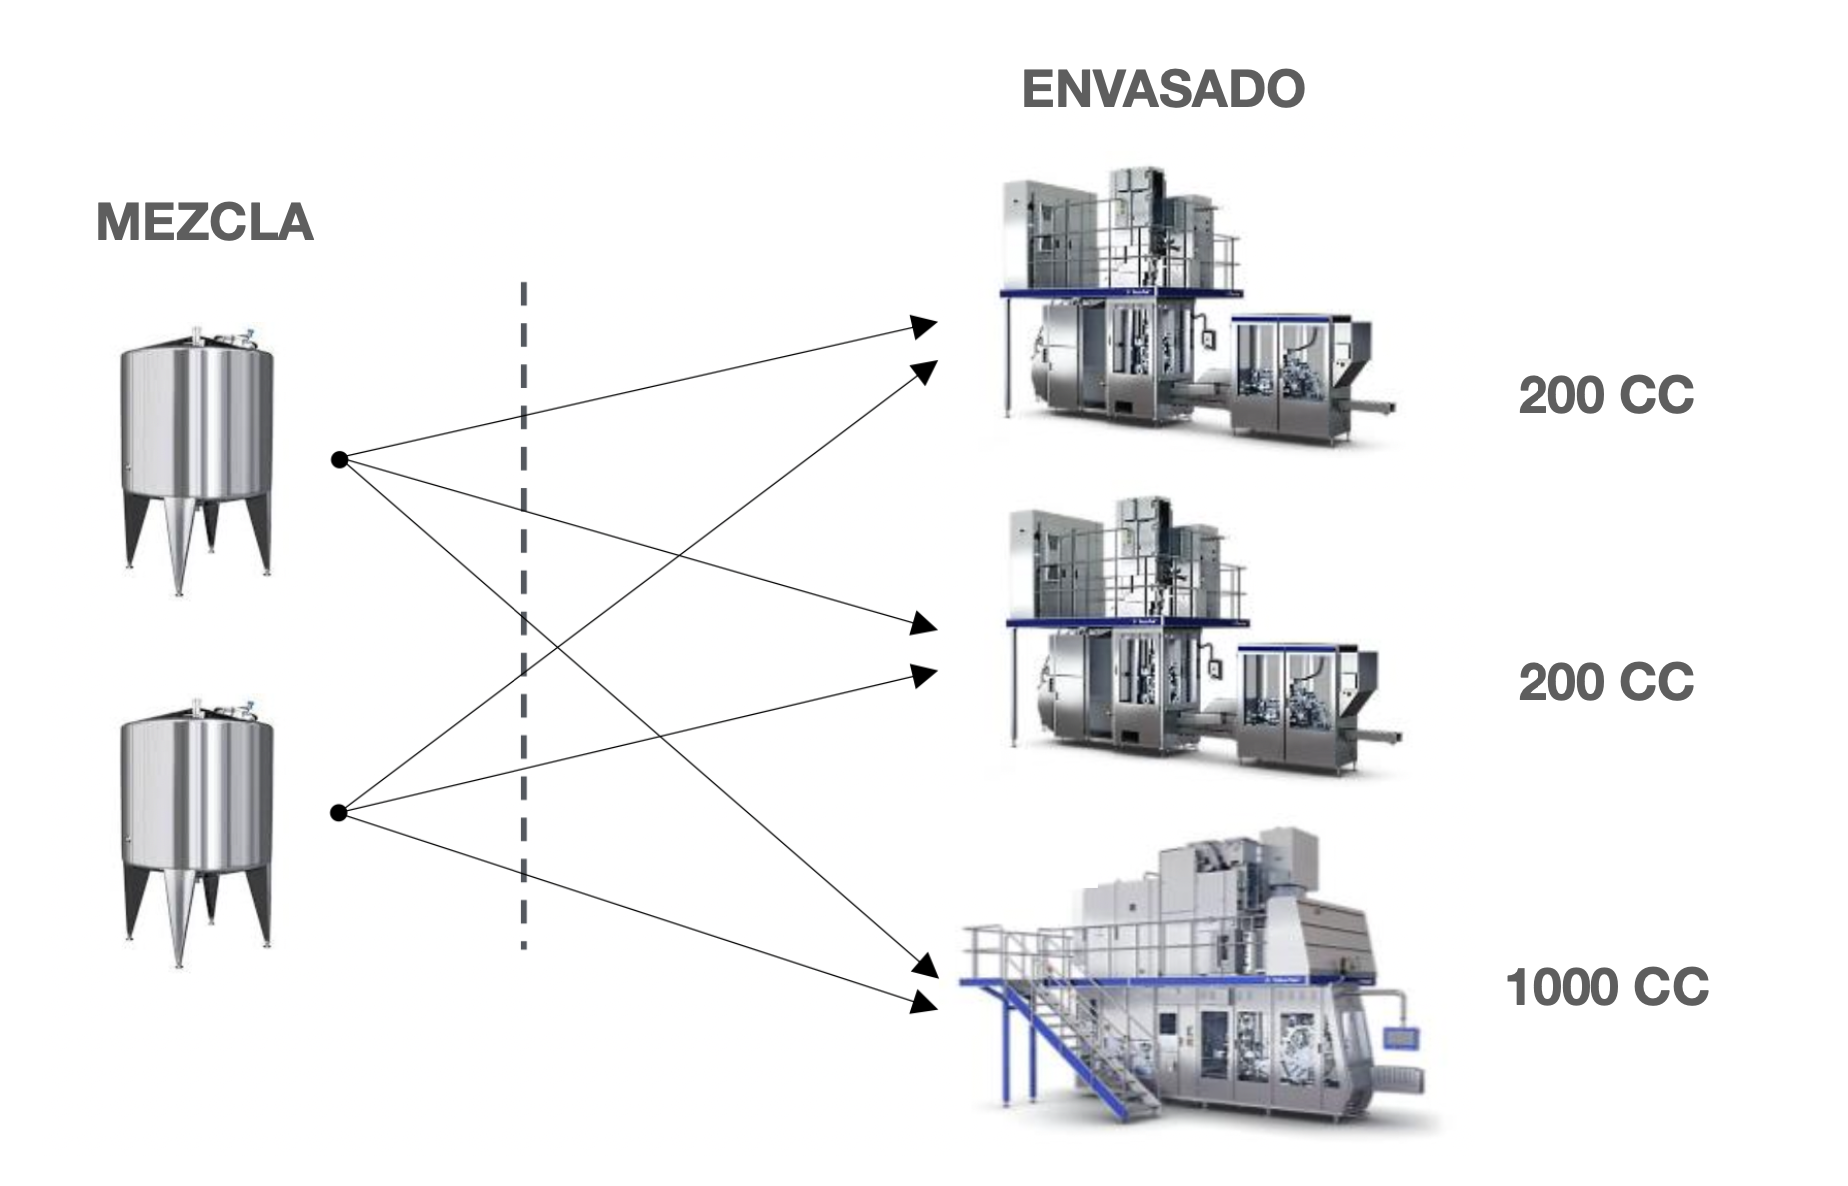

In [ ]:
combinations = []
quantities = []
for index, row in demanda_df.iterrows():
  flavour = row["SABOR"].lower()
  if flavour == "vanilla":
    favlour = "vainilla"
  format = f'{row["FORMATO (CC)"]}cc'
  qtty = row["UNIDADES"]
  combinations.append((flavour, format))
  quantities.append(qtty)

demanda = dict(zip(combinations, quantities))
demanda

{('chocolate', '200cc'): 927500,
 ('chocolate', '1000cc'): 80000,
 ('neutro', '200cc'): 577500,
 ('neutro', '1000cc'): 60000,
 ('vanilla', '200cc'): 350000,
 ('vanilla', '1000cc'): 80000}

In [ ]:
!pip install ortools matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatibl

✅ Makespan: 55 h


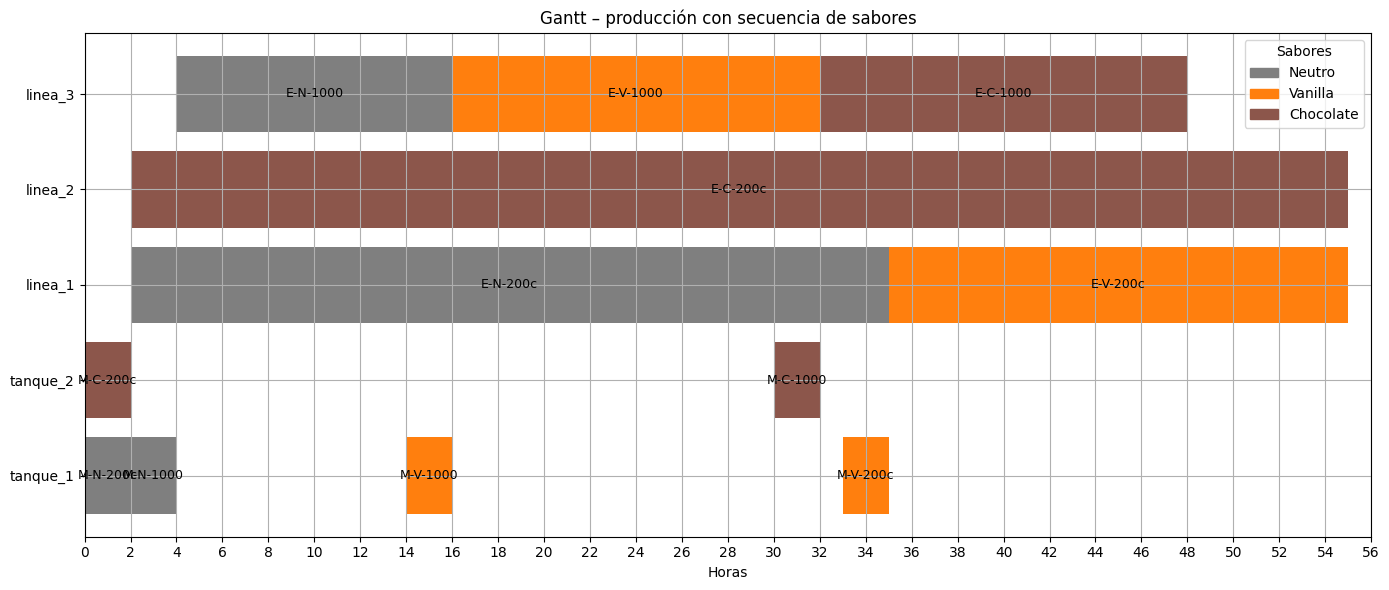

In [ ]:
#%%timeit
# ─────────────────────────────────────────────────────────────────────────────
#  Requisitos:
#     pip install ortools matplotlib
# ─────────────────────────────────────────────────────────────────────────────
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import math, itertools

# ── Datos --------------------------------------------------------------------
sabores   = ["neutro", "vanilla", "chocolate"]
formats   = ["200cc", "1000cc"]

tanques    = [1, 2]                          # mezcla
lineas_for = {"200cc": [1, 2], "1000cc": [3]}  # envasado
cap        = {1: 17_800, 2: 17_800, 3: 5_000}  # u/h

t_mezcla   = 2    # h
H          = 300  # horizonte

req = demanda

ord_idx = {'neutro': 0, 'vanilla': 1, 'chocolate': 2}   # orden deseado

# ── Modelo -------------------------------------------------------------------
mdl = cp_model.CpModel()
mez_por_tanque = {t: [] for t in tanques}
env_por_linea  = {l: [] for l in [1,2,3]}
tareas_plot    = {}  # para construir Gantt

for s in sabores:
    for f in formats:
        units = req[(s, f)]
        dur_env = math.ceil(units / cap[lineas_for[f][0]])

        # Mezcla: alternativas por tanque
        m_opts = []
        for t in tanques:
            use = mdl.NewBoolVar(f"m_use_{s}_{f}_{t}")
            st  = mdl.NewIntVar(0, H, f"m_ini_{s}_{f}_{t}")
            iv  = mdl.NewOptionalIntervalVar(st, t_mezcla, st + t_mezcla,
                                             use, f"m_iv_{s}_{f}_{t}")
            mez_por_tanque[t].append(iv)
            m_opts.append((use, st, t))
        mdl.AddExactlyOne(u for u,_,_ in m_opts)

        # Envasado: alternativas por línea válida
        e_opts = []
        for l in lineas_for[f]:
            use = mdl.NewBoolVar(f"e_use_{s}_{f}_{l}")
            st  = mdl.NewIntVar(0, H, f"e_ini_{s}_{f}_{l}")
            iv  = mdl.NewOptionalIntervalVar(st, dur_env, st + dur_env,
                                             use, f"e_iv_{s}_{f}_{l}")
            env_por_linea[l].append(iv)
            e_opts.append((use, st, l, dur_env))
        mdl.AddExactlyOne(u for u,_,_,_ in e_opts)

        # Precedencia mezcla → envasado (condicional)
        for m_use, m_st, _ in m_opts:
            for e_use, e_st, _, _ in e_opts:
                mdl.Add(e_st == m_st + t_mezcla).OnlyEnforceIf([m_use, e_use]) # aca arranca inmediatamente despues
                #mdl.Add(e_st >= m_st + t_mezcla).OnlyEnforceIf([m_use, e_use]) # esto seria con tiempo de buffer

        # Guardar para gráfico
        tareas_plot[(s,f)] = {"m_opts": m_opts, "e_opts": e_opts, "dur_env": dur_env}

# ── NoOverlap por recurso -----------------------------------------------------
for t in tanques:
    mdl.AddNoOverlap(mez_por_tanque[t])
for l in [1,2,3]:
    mdl.AddNoOverlap(env_por_linea[l])

# ── Secuencia de sabores (Neutro→Vainilla→Chocolate) por tanque y línea ------
for (s1,f1), (s2,f2) in itertools.permutations(req.keys(), 2):
    if ord_idx[s1] < ord_idx[s2]:                      # violaría el orden
        # Tanques
        for t in tanques:
            m1_use,m1_st,_ = next(opt for opt in tareas_plot[(s1,f1)]["m_opts"] if opt[2]==t)
            m2_use,m2_st,_ = next(opt for opt in tareas_plot[(s2,f2)]["m_opts"] if opt[2]==t)
            mdl.Add(m2_st >= m1_st + t_mezcla).OnlyEnforceIf([m1_use, m2_use])
        # Líneas (solo si ambos formatos admiten la misma línea)
        for l in [1,2,3]:
            if l in lineas_for[f1] and l in lineas_for[f2]:
                e1_use,e1_st,_,d1 = next(opt for opt in tareas_plot[(s1,f1)]["e_opts"] if opt[2]==l)
                e2_use,e2_st,_,_  = next(opt for opt in tareas_plot[(s2,f2)]["e_opts"] if opt[2]==l)
                mdl.Add(e2_st >= e1_st + d1).OnlyEnforceIf([e1_use, e2_use])

# ── Makespan -----------------------------------------------------------------
ends = [iv.EndExpr() for lst in env_por_linea.values() for iv in lst]
makespan = mdl.NewIntVar(0, H, "makespan")
mdl.AddMaxEquality(makespan, ends)
mdl.Minimize(makespan)

# ── Resolver -----------------------------------------------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 15
status = solver.Solve(mdl)

# ── Gantt --------------------------------------------------------------------
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print(f"✅ Makespan: {solver.Value(makespan)} h")
    active = []
    for (s,f), data in tareas_plot.items():
        # Mezclas activas
        for use, st, t in data["m_opts"]:
            if solver.Value(use):
                active.append(("mezcla",s,f,t, solver.Value(st), t_mezcla))
        # Envasados activos
        for use, st, l, d in data["e_opts"]:
            if solver.Value(use):
                active.append(("envasado",s,f,l, solver.Value(st), d))

    lanes = ["tanque_1","tanque_2","linea_1","linea_2","linea_3"]
    colors = {'neutro':'tab:grey','vanilla':'tab:orange','chocolate':'tab:brown'}

    fig, ax = plt.subplots(figsize=(14,6))
    for idx, lane in enumerate(lanes):
        for typ,s,f,r,st,dur in sorted(active, key=lambda x: x[4]):
            key = f"{'tanque' if typ=='mezcla' else 'linea'}_{r}"
            if key == lane:
                ax.broken_barh([(st,dur)], (idx-.4,.8),
                              facecolors=colors[s])
                # etiqueta legible
                short = f"{'M' if typ=='mezcla' else 'E'}-{s[0].upper()}-{f[:4]}"
                ax.text(st + dur/2, idx, short,
                        ha='center', va='center',
                        fontsize=9, color='black')

    ax.set_yticks(range(len(lanes))); ax.set_yticklabels(lanes)
    ax.set_xticks(range(0, 60, 2))       # ticks cada 2 horas
    ax.set_xlim(0, 56)
    ax.set_xlabel("Horas")
    ax.set_title("Gantt – producción con secuencia de sabores")
    ax.grid(True)

    import matplotlib.patches as mpatches
    leg = [mpatches.Patch(color=c, label=s.capitalize())
          for s,c in colors.items()]
    ax.legend(handles=leg, loc="upper right", title="Sabores")

    plt.tight_layout(); plt.show()

else:
    print("❌ El modelo no encontró solución")


In [ ]:
demanda_df

,SABOR,FORMATO (CC),UNIDADES
0,CHOCOLATE,200,927500
1,CHOCOLATE,1000,80000
2,NEUTRO,200,577500
3,NEUTRO,1000,60000
4,VANILLA,200,350000
5,VANILLA,1000,80000


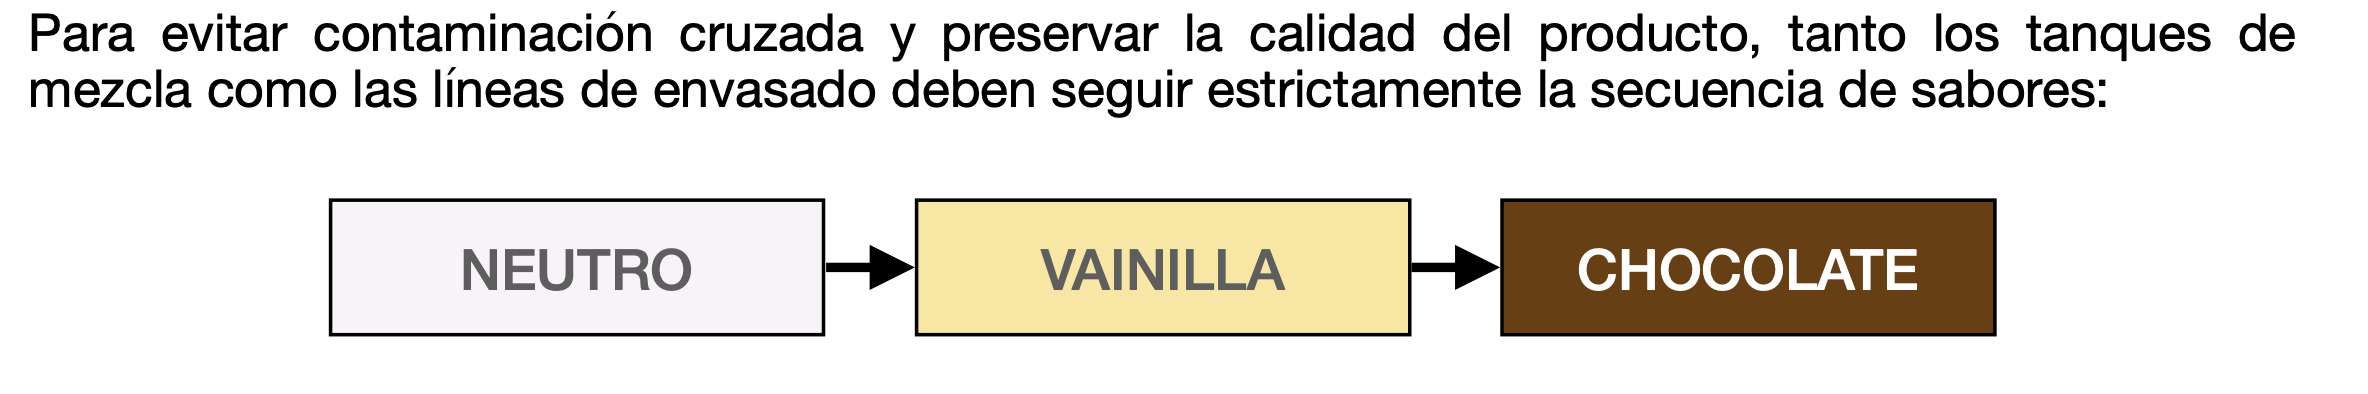

In [ ]:
from datetime import datetime, timedelta

# Definir la fecha y hora inicial (6 am de 2/06/2025)
fecha_inicial = datetime(2025, 6, 2, 6, 0, 0)

# Solicitar al usuario la cantidad de horas a sumar
try:
    horas_a_sumar = solver.Value(makespan)
except ValueError:
    print("Entrada no válida. Por favor, introduce un número entero.")
    exit()

# Sumar la cantidad de horas usando timedelta
fecha_final = fecha_inicial + timedelta(hours=horas_a_sumar)

# Imprimir el resultado
print(f"La fecha y hora inicial es: {fecha_inicial}")
print(f"Después de sumar {horas_a_sumar} horas, la fecha y hora final es: {fecha_final}")

La fecha y hora inicial es: 2025-06-02 06:00:00
Después de sumar 55 horas, la fecha y hora final es: 2025-06-04 13:00:00
